# Tutorial HowToAdaptiveOptics

This report provides a tutorial to use the code develloped to compute the PSIM for the ELT SCAO systems. 
The code is object-oriented and its architecture is quite inspired from the ([OOMAO simulator](https://github.com/cmcorreia/LAM-Public/tree/master/_libOomao)).



## Modules required
The code is written in Python 3 and requires the following modules

* **aotools**        => simulation of the phase screens
* **numba**          => required in aotools
* **joblib**         => paralleling computing
* **scikit-image**   => 2D interpolations
* **numexpr**        => memory optimized simple operations
* **astropy**        => handling of fits files

To be able to use the code you need to install the listed modules using the following command lines in a terminal:

*pip install aotools*

*pip install numba*

*pip install joblib*

*pip install scikit-image*

*pip install numexpr*

*pip install astropy*


### Import Modules

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Wed Oct 21 10:51:32 2020

@author: cheritie
"""
# commom modules
import matplotlib.pyplot as plt
import numpy             as np 
import time

# adding AO_Module to the path
import __load__oopao
__load__oopao.load_oopao()

# loading AO modules
from AO_modules.Atmosphere       import Atmosphere
from AO_modules.Pyramid          import Pyramid
from AO_modules.DeformableMirror import DeformableMirror
from AO_modules.MisRegistration  import MisRegistration
from AO_modules.Telescope        import Telescope
from AO_modules.Source           import Source

# calibration modules 
from AO_modules.calibration.compute_KL_modal_basis import compute_M2C
from AO_modules.calibration.ao_calibration import ao_calibration

# display modules
from AO_modules.tools.displayTools           import displayMap




======================================================================================>      
   ✸       *           °                *      *                                            
        °   ✸           ▄███▄   ▄███▄  ▄████▄   ▄███▄ * ▄███▄    =>               ▄▄▄▄           
  ✸            °       ██*  ██ ██   ██ ██   ██ ██   ██ ██   ██   ====>         ▄█▀▀  ▀▀█▄        
   *   °    ✸          ██   ██ ██ ° ██ ██   ██ ██ * ██ ██   ██   ==>          █▀ ▄█▀▀█▄ ▀█       
✸    *             °   ██   ██ ██   ██ █████▀  ██▄▄▄██ ██   ██   =========>  █▀ █▀ ▄▄ ▀█ ▀█      
           ✸   °       ██ * ██ ██   ██ ██      ██▀▀▀██ ██   ██   ========>   █▄ █▄ ▀▀ ▄█ ▄█      
 *    ✸     °          ██   ██ ██   ██ ██  *   ██   ██ ██*  ██   =>           █▄ ▀█▄▄█▀ ▄█       
    °        *    ✸     ▀███▀   ▀███▀  ██    ° ██   ██  ▀███▀    ==>           ▀█▄▄  ▄▄█▀        
         ✸       *          *         *                                           ▀▀▀▀           
===========================

### Read Parameter File

In [2]:
#import parameter file (dictionnary)

from parameter_files.parameterFile_VLT_I_Band_PWFS import initializeParameterFile

param = initializeParameterFile()
# the list of the keys contained in the dictionnary can be printed using the following lines
# for key, value in param.items() :
#     print (key, value)

Reading/Writting calibration data from data_calibration/
Writting output data in data_cl/


## Telescope Object

In [3]:
# create the Telescope object
tel = Telescope(resolution          = param['resolution'],\
                diameter            = param['diameter'],\
                samplingTime        = param['samplingTime'],\
                centralObstruction  = param['centralObstruction'])

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% TELESCOPE %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
     Diameter             8                [m]        
    Resolution           160             [pixels]     
    Pixel Size           0.05              [m]        
     Surface             50.0              [m2]       
Central Obstruction        0          [% of diameter]  
Pixels in the pupil      20108            [pixels]     
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


The mai informations contained in the telescope objects are the following: 
* tel. pupil : the pupil of the telescope as a 2D mask

* tel.src    : the source object attached to the telescope that contains the informations related to the wavelength, flux and phase. The default wavelength is the V band with a magnitude 0.

* tel.OPD    : the telescope OPD corresponding to the tel.src.phase 

All the properties of an object can be displayed using the .show() method: 

In [4]:
tel.show()

telescope:
          D: 8
          OPD: (160, 160)
          OPD_no_pupil: (160, 160)
          centralObstruction: 0
          em_field: (160, 160)
          fov: 0
          index_pixel_petals: None
          isInitialized: True
          isPaired: False
          isPetalFree: False
          pixelArea: 20108
          pixelSize: 0.05
          pupil: (160, 160)
          pupilLogical: (1, 20108)
          pupilReflectivity: (160, 160)
          resolution: 160
          samplingTime: 0.001
          spatialFilter: None
          src: source object
          tag: telescope


We can show the 2D map corresponding to the pupil or to the OPD:

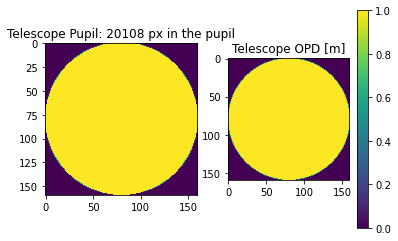

In [5]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(tel.pupil.T)
plt.title('Telescope Pupil: %.0f px in the pupil' %tel.pixelArea)
plt.subplot(1,2,2)
plt.imshow(tel.OPD.T)
plt.title('Telescope OPD [m]')
plt.colorbar()

And we can display the property of the child class tel.src that correspond to the default source object attached to the telescope:

In [6]:
tel.src.show()

source:
          altitude: inf
          bandwidth: 9e-08
          display_properties: False
          is_initialized: True
          magnitude: -0.0
          nPhoton: 8967391304.347826
          optBand: V
          phase: (160, 160)
          phase_no_pupil: (160, 160)
          tag: source
          type: NGS
          wavelength: 5.5e-07
          zeroPoint: 8967391304.347826


## Source Object
The Source object allows to access the properties related to the flux and wavelength of the object. We consider only on-axis objects as a start. 

In [7]:
ngs=Source(optBand   = param['opticalBand'],\
           magnitude = param['magnitude'])
print('NGS Object built!')

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% SOURCE %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
      Source          Wavelength     Zenith [arcsec]    Azimuth [deg]      Altitude [m]       Magnitude      Flux [phot/m2/s] 
------------------------------------------------------------------------------------------------------------------------------
       NGS             7.9e-07              0                 0                inf               8.0            4629306.6     
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
NGS Object built!


The NGS object has to be attached to a telescope object using the *  operator. 

This operation sets the telescope property tel.src to the ngs object considered. 

In [8]:
ngs*tel

The ngs object is now attached to the telescope. This means that the tel.src object now has a **phase** and a **fluxMap** property.

If we display the properties of ngs and tel.src, they are the same: 

In [9]:
# properties of ngs
ngs.show()
# properties of tel.src
tel.src.show()

source:
          altitude: inf
          bandwidth: 1.5e-07
          display_properties: True
          fluxMap: (160, 160)
          is_initialized: True
          magnitude: 8.0
          nPhoton: 4629306.603523155
          optBand: I
          phase: (160, 160)
          phase_no_pupil: (160, 160)
          tag: source
          type: NGS
          var: 3.469446951953614e-18
          wavelength: 7.9e-07
          zeroPoint: 7336956521.73913
source:
          altitude: inf
          bandwidth: 1.5e-07
          display_properties: True
          fluxMap: (160, 160)
          is_initialized: True
          magnitude: 8.0
          nPhoton: 4629306.603523155
          optBand: I
          phase: (160, 160)
          phase_no_pupil: (160, 160)
          tag: source
          type: NGS
          var: 3.469446951953614e-18
          wavelength: 7.9e-07
          zeroPoint: 7336956521.73913


We can compute and display the PSF corresponding to the telescope OPD and Source object attached to the telescope. 

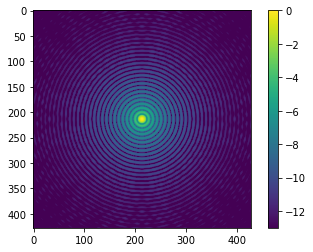

In [10]:

zeroPaddingFactor = 8

tel.computePSF(zeroPaddingFactor = zeroPaddingFactor)

PSF_normalized = tel.PSF/tel.PSF.max()

nPix = zeroPaddingFactor*tel.resolution//3

plt.figure()
plt.imshow(np.log(np.abs(PSF_normalized[nPix:-nPix,nPix:-nPix])))
plt.clim([-13,0])
plt.colorbar()



## Atmosphere Object
The atmosphere object is created mainly from the telescope properties (diameter, pupil, samplingTime)and the *r0* and *L0* parameters. It is possible to generate multi-layers, each one is a child-class of the atmosphere object with its own set of parameters (windSpeed, Cn^2,windDirection, altitude). 


In [11]:
atm=Atmosphere(telescope     = tel,\
               r0            = param['r0'],\
               L0            = param['L0'],\
               windSpeed     = param['windSpeed'],\
               fractionalR0  = param['fractionnalR0'],\
               windDirection = param['windDirection'],\
               altitude      = param['altitude'])

print('Atmosphere Object built!')

Atmosphere Object built!


The atmosphere object has to be initialized using:

In [12]:
# initialize atmosphere
atm.initializeAtmosphere(tel)
print('Done!')

Creation of layer1/5 ...
-> Computing the initial phase screen...
initial phase screen : 0.027467727661132812 s
ZZt.. : 0.9668419361114502 s
ZXt.. : 0.36299848556518555 s
XXt.. : 0.16903352737426758 s
Done!
Creation of layer2/5 ...
-> Computing the initial phase screen...
initial phase screen : 0.016000032424926758 s
ZZt.. : 0.0 s
ZXt.. : 0.0 s
XXt.. : 0.0 s
SCAO system considered: covariance matrices were already computed!
Done!
Creation of layer3/5 ...
-> Computing the initial phase screen...
initial phase screen : 0.01599860191345215 s
ZZt.. : 0.0 s
ZXt.. : 0.0 s
XXt.. : 0.0 s
SCAO system considered: covariance matrices were already computed!
Done!
Creation of layer4/5 ...
-> Computing the initial phase screen...
initial phase screen : 0.02002716064453125 s
ZZt.. : 0.0 s
ZXt.. : 0.0 s
XXt.. : 0.0 s
SCAO system considered: covariance matrices were already computed!
Done!
Creation of layer5/5 ...
-> Computing the initial phase screen...
initial phase screen : 0.01599884033203125 s
ZZt

Similarly to the Source object, the atmosphere object can be paired to the telescope **+**. 

In that case, if the atmosphere OPD is updated, the telescope OPD is automatically updated.

In [ ]:
tel+atm
print(tel.isPaired)

We can display the properties of the telescope object:

In [ ]:
plt.figure()
plt.imshow(tel.OPD.T)
plt.title('Telescope OPD [m]')
plt.colorbar()

plt.figure()
plt.imshow(tel.src.phase.T)
plt.colorbar()
plt.title('NGS Phase [rad]')

The atmosphere and the telescope can be separated using the **-** operator. This brings back the system to a diffraction limited case with a flat OPD.

In [13]:
tel-atm
print(tel.isPaired)

Telescope and Atmosphere separated!
False


The atmosphere layers can be displayed using atm.display_atm_layers() function which displays the pupil footprint


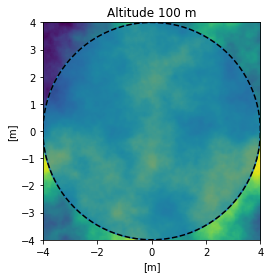

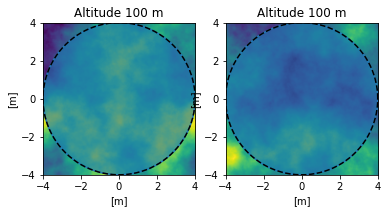

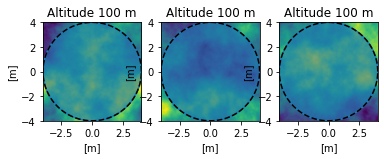

In [17]:
atm.display_atm_layers(layer_index=[0])
atm.display_atm_layers(layer_index=[0,1])
atm.display_atm_layers(layer_index=[0,1,3])

## Deformable Mirror Object
The deformable mirror is mainly characterized with its influence functions. They can be user-defined and loaded in the model but the default case is a cartesian DM with gaussian influence functions and normalized to 1. 
The DM is always defined in the pupil plane. 


In [18]:
dm=DeformableMirror(telescope    = tel,\
                    nSubap       = param['nSubaperture'],\
                    mechCoupling = param['mechanicalCoupling'])
print('Done!')

No coordinates loaded.. taking the cartesian geometry as a default
Generating a Deformable Mirror: 
Computing the 2D zonal modes...
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% DEFORMABLE MIRROR %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Controlled Actuators        357        
         M4                False       
        Pitch               0.4               [m]        
 Mechanical Coupling        0.45              [%]        
-------------------------------------------------------------------------------
Mis-registration:
Rotation [deg]	Shift X [m]	Shift Y [m]	Radial Scaling [%]	Tangential Scaling [%]
      0       	     0     	     0     	        0         	          0           
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Done!


We can display the cube of the influence functions to display the position of the actuators.


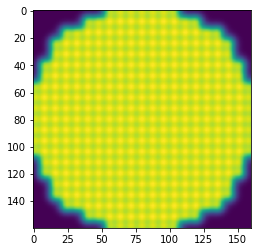

In [19]:
cube_IF = np.reshape(np.sum(dm.modes**3, axis =1),[tel.resolution,tel.resolution])
plt.figure()
plt.imshow(cube_IF.T)

### Light propagation
The light can be propagate through the DM using the ***** operator. 

To update the DM surface, the property **dm.coefs** must be updated to set the new values of the DM coefficients.

Typically, using a random command vector, we can propagate the light through the DM (light is reflected hence the sign change and the factor 2 in OPD):

Telescope and Atmosphere separated!


Text(0.5, 1.0, 'Telescope OPD [m]')

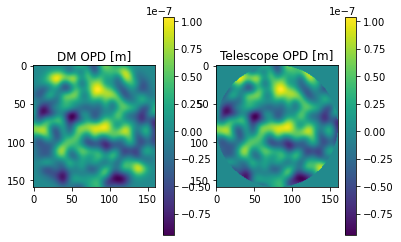

In [20]:
tel-atm

dm.coefs = (np.random.rand(dm.nValidAct)-0.5)*100e-9
tel*dm
plt.figure()
plt.subplot(121)
plt.imshow(dm.OPD)
plt.title('DM OPD [m]')
plt.colorbar()
plt.subplot(122)
plt.imshow(tel.OPD)
plt.colorbar()
plt.title('Telescope OPD [m]')

### Mis-registrations
The DM/WFS mis-registrations are applied directly in the DM space, applying the transformations on the DM influence functions. 

First we create a **MisRegistration Object** that is initialized to 0. 

We can then update the values of the mis-registrations and input it to the DM model:

No coordinates loaded.. taking the cartesian geometry as a default
Generating a Deformable Mirror: 
Computing the 2D zonal modes...
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% DEFORMABLE MIRROR %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Controlled Actuators        357        
         M4                False       
        Pitch               0.4               [m]        
 Mechanical Coupling        0.45              [%]        
-------------------------------------------------------------------------------
Mis-registration:
Rotation [deg]	Shift X [m]	Shift Y [m]	Radial Scaling [%]	Tangential Scaling [%]
      3       	   0.12    	    0.1    	        0         	          0           
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Done!


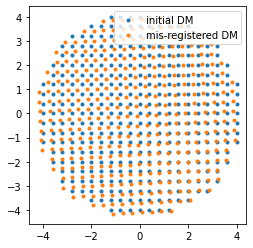

In [21]:
misReg = MisRegistration()
misReg.rotationAngle = 3
misReg.shiftX        = 0.3*param['diameter']/param['nSubaperture']
misReg.shiftY        = 0.25*param['diameter']/param['nSubaperture']

dm_misReg = DeformableMirror(telescope    = tel,\
                    nSubap       = param['nSubaperture'],\
                    mechCoupling = param['mechanicalCoupling'],\
                    misReg       = misReg)
print('Done!')

plt.figure()
plt.plot(dm.coordinates[:,0],dm.coordinates[:,1],'.')
plt.plot(dm_misReg.coordinates[:,0],dm_misReg.coordinates[:,1],'.')
plt.axis('square')
plt.legend(['initial DM','mis-registered DM'])


## Pyramid Object
The pyramid object consists mainly in defining the PWFS mask to apply the filtering of the electro-magnetic field. 
Many parameters can allow to tune the pyramid model:
* Centering of the mask and of the FFT on 1 or 4 pixels
* Modulation radius in λ/D. By default the number of modulation points ensures to have one point every λ/D on the circular trajectory but this sampling can be modified by the user. The number of modulation points is a multiple of 4 to ensure that each quadrant has the same number of modulation points.
* The modulation value for the calibration and selection of the valid pixels
* PWFS pupils separation, either for a perfect pyramid with a single value or for an imperfect pyramid with 8 values (shift X and Y for each PWFS pupil) . 
* The type of post-processing of the PWFS signals (slopes-maps, full-frame,etc). To be independent from this choice, the pyramid signals are named “wfs.pyramidSignal_2D” for either the Slopes-Maps or the camera frame and “wfs.pyramidSignal” for the signal reduced to the valid pixels considered.
* The intensity threshold to select the valid pixel 

Some optional features can be user-defined:
* Zero-padding value
* Number of  pixel on the edge of the Pyramid pupils
* The units of the WFS signals can be calibrated using a ramp of Tip/Tilt


In addition, the Pyramid object has a Detector object as a child-class that provides the pyramid signals. It can be access through **wfs.cam**

In [22]:
# make sure tel and atm are separated to initialize the PWFS
tel-atm

# create the Pyramid Object
wfs = Pyramid(nSubap                = param['nSubaperture'],\
              telescope             = tel,\
              modulation            = param['modulation'],\
              lightRatio            = param['lightThreshold'],\
              n_pix_separation      = param['n_pix_separation'],\
              psfCentering          = param['psfCentering'],\
              postProcessing        = param['postProcessing'])


Telescope and Atmosphere separated!
Pyramid Mask initialization...
Selection of the valid pixels...
The valid pixel are selected on flux considerations
Acquisition of the reference slopes and units calibration...
WFS calibrated!
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% PYRAMID WFS %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
 Pupils Diameter          20             [pixels]     
Pupils Separation         4              [pixels]     
       FoV               3.26            [arcsec]     
  TT Modulation           3             [lamda/D]     
PSF Core Sampling         1             [pixel(s)]    
   Valid Pixels          664            [pixel(s)]    
Signal Computation    slopesMaps    
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


The light can be propagated to the WFS through the different objects with using the ***** operator:

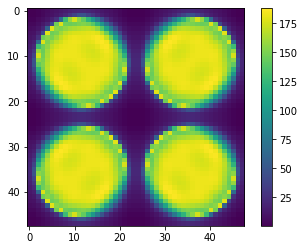

In [23]:
tel*wfs

plt.figure()
plt.imshow(wfs.cam.frame)
plt.colorbar()

We can display the PWFS signals that corresponds to a random actuation of the DM:

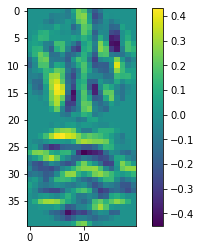

In [24]:
dm.coefs = (np.random.rand(dm.nValidAct)-0.5)*100e-9
tel*dm*wfs

plt.figure()
plt.imshow(wfs.pyramidSignal_2D)
plt.colorbar()

## Modal Basis
In this tutorial, we compute the mode-to-commands matrix (M2C) using the codes provided by C.Verinaud. It corresponds to a KL modal basis orthogonolized in the DM space.

In [25]:
foldername_M2C  = None  # name of the folder to save the M2C matrix, if None a default name is used 
filename_M2C    = None  # name of the filename, if None a default name is used 


M2C =  compute_M2C(param            = param,\
                  telescope         = tel,\
                  atmosphere        = atm,\
                  deformableMirror  = dm,\
                  nameFolder        = None,\
                  nameFile          = None,\
                  remove_piston     = True)

COMPUTING TEL*DM...
 
PREPARING IF_2D...
 
Computing Specific Modes ...
 
COMPUTING VON KARMAN 2D PSD...
 
COMPUTING COV MAT HHt...
 
RECOMMENDED NDIVL =  0
TIME ELAPSED: 1 sec. COMPLETED: 100 %
SERIALIZING IFs...
 
SERIALIZING Specific Modes...
 
COMPUTING IFs CROSS PRODUCT...
 
NMAX =  299
RMS opd error = [[1.02733271e-08 1.55041158e-08 1.55041158e-08]]
RMS Positions = [[6.72793909e-08 3.23846105e-07 3.23846105e-07]]
MAX Positions = [[4.41524726e-07 8.09728626e-07 8.09728626e-07]]
CHECKING ORTHONORMALITY OF SPECIFIC MODES...
 
Orthonormality error for SpM =  3.3306690738754696e-16
BUILDING SEED BASIS ...
 
Orthonormality error for 300 modes of the Seed Basis =  2.1094237467877974e-14
KL WITH DOUBLE DIAGONALISATION: COVARIANCE ERROR =  5.1836565927055575e-14
Orthonormality error for 300 modes of the KL Basis =  1.9095836023552692e-14
Piston removed from the modal basis!


## Interaction Matrix
The interaction matrix can be computed using the M2C matrix and the function interactionMatrix.
The output is stored as a class that contains all the informations about the inversion (SVD) such as eigenValues, reconstructor, etc. 

It is possible to add a **phaseOffset** to the interactionMatrix measurement. 

In [ ]:
#%% to manually measure the interaction matrix
#
## amplitude of the modes in m
#stroke=1e-9
## Modal Interaction Matrix 
#M2C = M2C[:,:param['nModes']]
#from AO_modules.calibration.InteractionMatrix import interactionMatrix
#
#calib = interactionMatrix(ngs            = ngs,\
#                             atm            = atm,\
#                             tel            = tel,\
#                             dm             = dm,\
#                             wfs            = wfs,\
#                             M2C            = M2C,\
#                             stroke         = stroke,\
#                             phaseOffset    = 0,\
#                             nMeasurements  = 100,\
#                             noise          = False)
#
#plt.figure()
#plt.plot(np.std(calib.D,axis=0))
#plt.xlabel('Mode Number')
#plt.ylabel('WFS slopes STD')
#plt.ylabel('Optical Gain')

In [26]:
ao_calib =  ao_calibration(param            = param,\
                           ngs              = ngs,\
                           tel              = tel,\
                           atm              = atm,\
                           dm               = dm,\
                           wfs              = wfs,\
                           nameFolderIntMat = None,\
                           nameIntMat       = None,\
                           nameFolderBasis  = None,\
                           nameBasis        = None,\
                           nMeasurements    = 100)


Loading the KL Modal Basis from: data_calibration/M2C_160_res
Computing the pseudo-inverse of the modal basis...
Diagonality criteria: 1.9373391779708982e-13 -- using the fast computation
Loading Interaction matrix data_calibration/VLT_I_band_20x20/zonal_interaction_matrix_160_res_3_mod_slopesMaps_psfCentering_False...
Done!
No Modal Gains found. All gains set to 1


In [ ]:
## Display Modal Basis


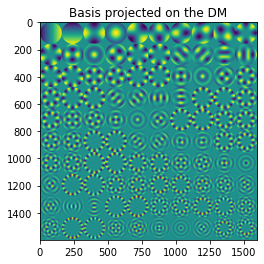

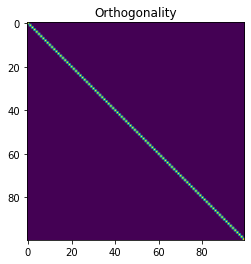

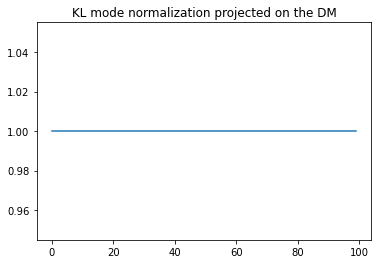

In [27]:

# project the mode on the DM
dm.coefs = ao_calib.M2C[:,:100]

tel*dm
#
# show the modes projected on the dm, cropped by the pupil and normalized by their maximum value
displayMap(tel.OPD,norma=True)
plt.title('Basis projected on the DM')

KL_dm = np.reshape(tel.OPD,[tel.resolution**2,tel.OPD.shape[2]])

covMat = (KL_dm.T @ KL_dm) / tel.resolution**2

plt.figure()
plt.imshow(covMat)
plt.title('Orthogonality')
plt.show()

plt.figure()
plt.plot(np.round(np.std(np.squeeze(KL_dm[tel.pupilLogical,:]),axis = 0),5))
plt.title('KL mode normalization projected on the DM')
plt.show()


## Closed Loop
Here is a code to do a closed-loop simulation using the PSIM code:

Telescope and Atmosphere combined!


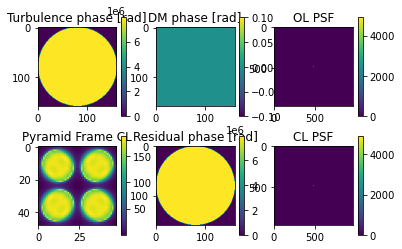

Elapsed time: 0.26097869873046875 s


<Figure size 432x288 with 0 Axes>

Loop0/20 Turbulence: 574.6949774093214 -- Residual:574.6949774093214

Elapsed time: 0.24351143836975098 s


<Figure size 432x288 with 0 Axes>

Loop1/20 Turbulence: 572.7662284287878 -- Residual:572.7662284287878

Elapsed time: 0.23600149154663086 s


<Figure size 432x288 with 0 Axes>

Loop2/20 Turbulence: 570.9053933544847 -- Residual:475.68774056630815

Elapsed time: 0.24131536483764648 s


<Figure size 432x288 with 0 Axes>

Loop3/20 Turbulence: 569.1341310615086 -- Residual:381.91758784509835

Elapsed time: 0.2295854091644287 s


<Figure size 432x288 with 0 Axes>

Loop4/20 Turbulence: 567.3493316520531 -- Residual:298.71312188056424

Elapsed time: 0.2660033702850342 s


<Figure size 432x288 with 0 Axes>

Loop5/20 Turbulence: 565.4367179101629 -- Residual:230.82652387627422

Elapsed time: 0.23199892044067383 s


<Figure size 432x288 with 0 Axes>

Loop6/20 Turbulence: 563.4996031710361 -- Residual:179.0003136452009

Elapsed time: 0.22700262069702148 s


<Figure size 432x288 with 0 Axes>

Loop7/20 Turbulence: 561.608604558837 -- Residual:143.97079220249358

Elapsed time: 0.2550032138824463 s


<Figure size 432x288 with 0 Axes>

Loop8/20 Turbulence: 559.7842698343633 -- Residual:123.16286823263093

Elapsed time: 0.23512554168701172 s


<Figure size 432x288 with 0 Axes>

Loop9/20 Turbulence: 557.9597375251852 -- Residual:112.54763077433859

Elapsed time: 0.25809788703918457 s


<Figure size 432x288 with 0 Axes>

Loop10/20 Turbulence: 556.0560298034015 -- Residual:107.8349167861698

Elapsed time: 0.235368013381958 s


<Figure size 432x288 with 0 Axes>

Loop11/20 Turbulence: 554.0708506845962 -- Residual:106.00845282094443

Elapsed time: 0.2500014305114746 s


<Figure size 432x288 with 0 Axes>

Loop12/20 Turbulence: 552.1401015297779 -- Residual:104.79715415102939

Elapsed time: 0.23400187492370605 s


<Figure size 432x288 with 0 Axes>

Loop13/20 Turbulence: 550.3174245112568 -- Residual:103.9757185611531

Elapsed time: 0.2351970672607422 s


<Figure size 432x288 with 0 Axes>

Loop14/20 Turbulence: 548.5438506751865 -- Residual:103.81732787526765

Elapsed time: 0.25600171089172363 s


<Figure size 432x288 with 0 Axes>

Loop15/20 Turbulence: 546.7389709414983 -- Residual:103.7318205168882

Elapsed time: 0.26900243759155273 s


<Figure size 432x288 with 0 Axes>

Loop16/20 Turbulence: 544.8768471496747 -- Residual:103.19510387737128

Elapsed time: 0.24999547004699707 s


<Figure size 432x288 with 0 Axes>

Loop17/20 Turbulence: 542.9709961822729 -- Residual:102.69795109625295

Elapsed time: 0.23500394821166992 s


<Figure size 432x288 with 0 Axes>

Loop18/20 Turbulence: 541.1050675633807 -- Residual:102.36590466967425

Elapsed time: 0.2249917984008789 s


<Figure size 432x288 with 0 Axes>

Loop19/20 Turbulence: 539.2928411542072 -- Residual:102.11674885785669



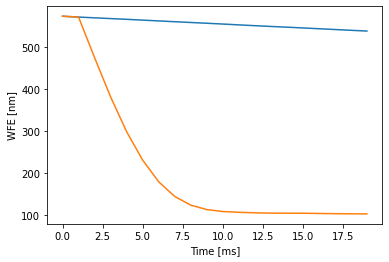

In [28]:

# These are the calibration data used to close the loop
calib_CL    = ao_calib.calib
M2C_CL      = ao_calib.M2C

param['nLoop'] =100
plt.close('all')

# combine telescope with atmosphere
tel+atm

# initialize DM commands
dm.coefs=0
ngs*tel*dm*wfs

plt.ion()
# setup the display
fig         = plt.figure(79)
ax1         = plt.subplot(2,3,1)
im_atm      = ax1.imshow(tel.src.phase)
plt.colorbar(im_atm)
plt.title('Turbulence phase [rad]')

ax2         = plt.subplot(2,3,2)
im_dm       = ax2.imshow(dm.OPD*tel.pupil)
plt.colorbar(im_dm)
plt.title('DM phase [rad]')
tel.computePSF(zeroPaddingFactor=6)

ax4         = plt.subplot(2,3,3)
im_PSF_OL   = ax4.imshow(tel.PSF)
plt.colorbar(im_PSF_OL)
plt.title('OL PSF')


ax3         = plt.subplot(2,3,5)
im_residual = ax3.imshow(tel.src.phase)
plt.colorbar(im_residual)
plt.title('Residual phase [rad]')

ax5         = plt.subplot(2,3,4)
im_wfs_CL   = ax5.imshow(wfs.cam.frame)
plt.colorbar(im_wfs_CL)
plt.title('Pyramid Frame CL')

ax6         = plt.subplot(2,3,6)
im_PSF      = ax6.imshow(tel.PSF)
plt.colorbar(im_PSF)
plt.title('CL PSF')

plt.show()

param['nLoop'] = 20
# allocate memory to save data
SR                      = np.zeros(param['nLoop'])
total                   = np.zeros(param['nLoop'])
residual                = np.zeros(param['nLoop'])
wfsSignal               = np.arange(0,wfs.nSignal)*0

# loop parameters
gainCL                  = 0.6
wfs.cam.photonNoise     = True
display                 = True

for i in range(param['nLoop']):
    a=time.time()
    # update phase screens => overwrite tel.OPD and consequently tel.src.phase
    atm.update()
     # save phase variance
    total[i]=np.std(tel.OPD[np.where(tel.pupil>0)])*1e9
     # save turbulent phase
    turbPhase = tel.src.phase
    if display == True:
           # compute the OL PSF and update the display
       tel.computePSF(zeroPaddingFactor=6)
       im_PSF_OL.set_data(np.log(tel.PSF/tel.PSF.max()))
       im_PSF_OL.set_clim(vmin=-3,vmax=0)
       
     # propagate to the WFS with the CL commands applied
    tel*dm*wfs
    
     # save the DM OPD shape
    dmOPD=tel.pupil*dm.OPD*2*np.pi/ngs.wavelength
    
    dm.coefs=dm.coefs-gainCL*M2C_CL@calib_CL.M@wfsSignal
     # store the slopes after computing the commands => 2 frames delay
    wfsSignal=wfs.pyramidSignal
    b= time.time()
    print('Elapsed time: ' + str(b-a) +' s')
    # update displays if required
    if display==True:
        
       # Turbulence
       im_atm.set_data(turbPhase)
       im_atm.set_clim(vmin=turbPhase.min(),vmax=turbPhase.max())
       # WFS frame
       C=wfs.cam.frame
       im_wfs_CL.set_data(C)
       im_wfs_CL.set_clim(vmin=C.min(),vmax=C.max())
       # DM OPD
       im_dm.set_data(dmOPD)
       im_dm.set_clim(vmin=dmOPD.min(),vmax=dmOPD.max())
     
       # residual phase
       D=tel.src.phase
       D=D-np.mean(D[tel.pupil])
       im_residual.set_data(D)
       im_residual.set_clim(vmin=D.min(),vmax=D.max()) 
    
       tel.computePSF(zeroPaddingFactor=6)
       im_PSF.set_data(np.log(tel.PSF/tel.PSF.max()))
       im_PSF.set_clim(vmin=-4,vmax=0)
       plt.draw()
       plt.show()
       plt.pause(0.001)
    
    
    SR[i]=np.exp(-np.var(tel.src.phase[np.where(tel.pupil==1)]))
    residual[i]=np.std(tel.OPD[np.where(tel.pupil>0)])*1e9
    OPD=tel.OPD[np.where(tel.pupil>0)]

    print('Loop'+str(i)+'/'+str(param['nLoop'])+' Turbulence: '+str(total[i])+' -- Residual:' +str(residual[i])+ '\n')

#%%
plt.figure()
plt.plot(total)
plt.plot(residual)
plt.xlabel('Time [ms]')
plt.ylabel('WFE [nm]')

plt.pause(10)
